We observed that the density fields for different nbody simulators differed according to a magnitude shift.

This notebook is to compare them to quijote and fix them.

In [2]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'  # noqa, must go before jax

import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin
from collections import defaultdict

from pmwd import linear_power
from pmwd.spec_util import powspec
from pmwd.vis_util import simshow
from pmwd import (Configuration, Cosmology, boltzmann)
import logging

## Inspect quijote white noise

In [2]:
def load_white_noise(path_to_ic, N, quijote=False):
    """Loading in Fourier space."""
    num_modes_last_d = N // 2 + 1
    with open(path_to_ic, 'rb') as f:
        if quijote:
            _ = np.fromfile(f, np.uint32, 1)[0]
        modes = np.fromfile(f, np.complex128, -1)
        modes = modes.reshape((N, N, num_modes_last_d))
    return modes

# N = 1024
# i = 3
# path = f'/home/mattho/git/ltu-cmass/data/quijote/wn/N{N}/wn_{i}.dat'
# ics = load_white_noise(path, N, quijote=True)
# c = np.fft.irfftn(ics)


N = 256
i = 3
path = f'/home/mattho/git/ltu-cmass/data/quijote/wn/N{N}/wn_{i}.dat'
fics = load_white_noise(path, N, quijote=True)
f = np.fft.irfftn(fics)


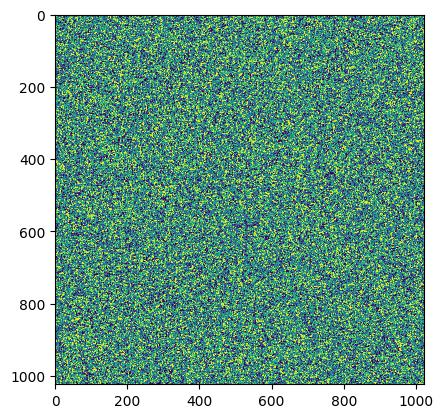

In [3]:
# plt.imshow(ics[15].real)
plt.imshow(c[15], vmin=-1e-5, vmax=1e-5)

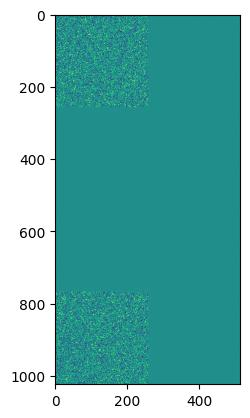

In [4]:
plt.imshow(ics[100].imag, vmin=-1, vmax=1)

In [5]:
ics.std()

0.3546080838546856

In [26]:
from numpy.lib.stride_tricks import sliding_window_view

def sum_pool3d(arr, stride):
    d = sliding_window_view(arr, 3*(stride,))
    return d[::stride, ::stride, ::stride].sum(axis=(3,4,5))

In [27]:
e = sum_pool3d(c, 4)
e.shape

(256, 256, 256)

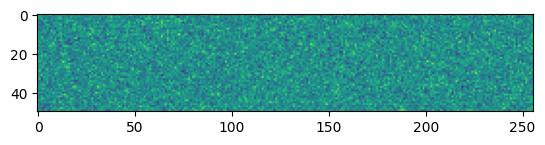

In [31]:
plt.imshow(e[3,:50], vmin=-1e-3, vmax=1e-3)

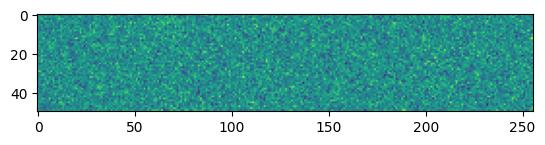

In [30]:
plt.imshow(f[3,:50], vmin=-1e-3, vmax=1e-3)

In [25]:
np.mean(e), np.mean(f)

(-2.8149990220945223e-23, -3.825710333057753e-24)

In [17]:
efft = np.fft.rfftn(e)

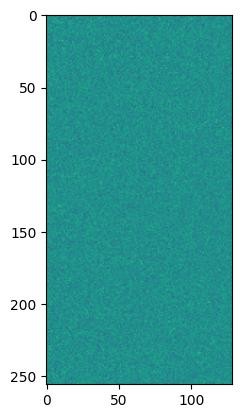

In [18]:
plt.imshow(efft[15].imag, vmin=-1e-1, vmax=1e-1)

In [14]:
f.var()/e.var()

5122.997961880596

In [10]:
np.sqrt(4**3)

8.0

In [2]:
from pmwd import white_noise
from pmwd import (
    Configuration,
    Cosmology,
    boltzmann,
    linear_modes,
    lpt,
    nbody,
    scatter,
)

def configure_pmwd(L, N, N_steps, supersampling, ai, af, cosmo):
    ptcl_spacing = L/N
    ptcl_grid_shape = (N,)*3
    pmconf = Configuration(ptcl_spacing, ptcl_grid_shape,
                           a_start=ai, a_stop=af,
                           a_nbody_maxstep=(af-ai)/N_steps,
                           mesh_shape=supersampling)
    pmcosmo = Cosmology.from_sigma8(
        pmconf, sigma8=cosmo[4], n_s=cosmo[3], Omega_m=cosmo[0],
        Omega_b=cosmo[1], h=cosmo[2])
    pmcosmo = boltzmann(pmcosmo, pmconf)
    return pmconf, pmcosmo

conf, _ = configure_pmwd(1000, 128, 16, 1, 1e-3, 1, [0.3, 0.05, 0.7, 0.96, 0.8])

p = white_noise(N, conf)
p = np.fft.irfftn(p)

: 

: 

: 

In [ ]:
p.shape

(128, 128, 128)

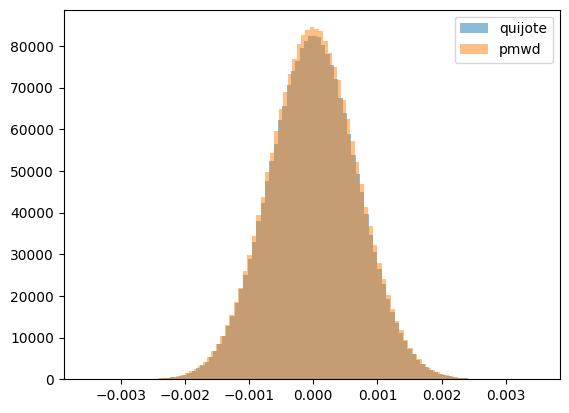

In [39]:
plt.hist(c.flatten(), bins=100, alpha=0.5, label='quijote');
plt.hist(p.flatten(), bins=100, alpha=0.5, label='pmwd');
plt.legend()

## Compare 1 Gpc forward models

In [59]:
lhid = 99
vmin, vmax = -1, 6

In [60]:
# Load quijote
datadir = '/home/mattho/data/quijote/density_field/latin_hypercube/'
qrho = np.load(pjoin(datadir, str(lhid), 'df_m_128_z=0.npy'))

In [98]:
# Load borg
datadir = '/home/mattho/data/cmass-ili/quijote_z0/borg2lpt/L1000-N128/'
brho = np.load(pjoin(datadir, str(lhid), 'rho.npy'))
bvel = np.load(pjoin(datadir, str(lhid), 'fvel.npy'))

In [99]:
# Load pmwd
datadir = '/home/mattho/data/cmass-ili/calib_1gpch/pmwd/L1000-N128/'
prho = np.load(pjoin(datadir, str(lhid), 'rho.npy'))
pvel = np.load(pjoin(datadir, str(lhid), 'fvel.npy'))
prho.shape

(128, 128, 128)

In [100]:
# # load fastpm
# import pickle
# filename = pjoin('/home/mattho/data/cmass-ili', 'old', 'density_fastpm_B2_N_384_LH_0__5.pk')
# with open(filename ,'rb') as f:
#     data = pickle.load(f)
# frho = data[lhid]

Text(0.5, 1.0, 'borg')

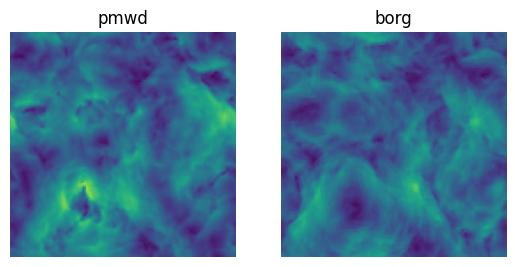

In [102]:
f,axs = plt.subplots(1,2)
i = 15 # np.random.randint(0, len(pvel))
axs[0].imshow(np.linalg.norm(pvel[i], axis=-1), vmin=0, vmax=1500)
axs[1].imshow(np.linalg.norm(bvel[i], axis=-1), vmin=0, vmax=1500)
# axs[0].imshow(pvel[i,:,:,0])
# axs[1].imshow(vel[i,:,:,0])
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('pmwd')
axs[1].set_title('borg')

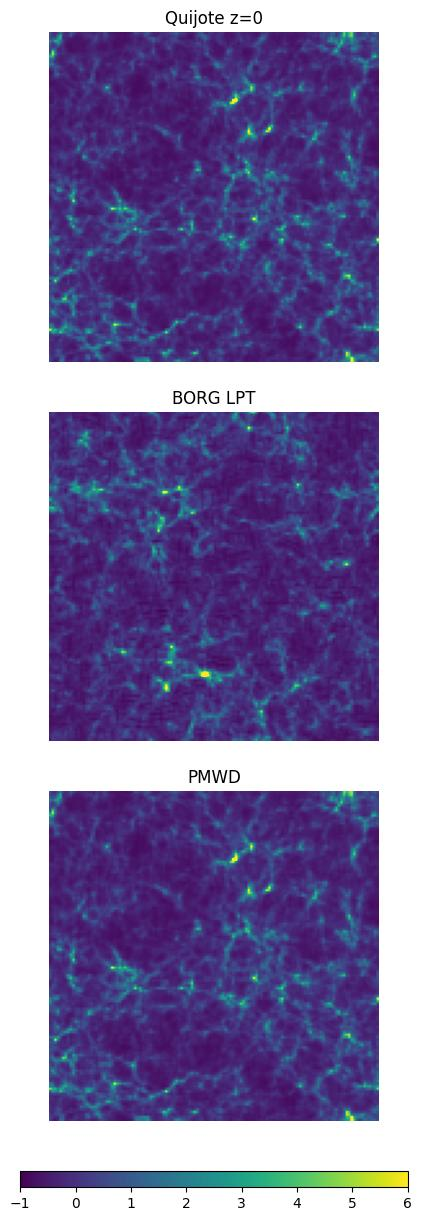

In [103]:
d = 0.05

# plot slices of all 3
fig, axs = plt.subplots(4, 1, figsize=(5,15),
                        gridspec_kw={'height_ratios': [1, 1, 1, 0.05]})

N = qrho.shape[0]//2
delta = int(N*d)
x_ = np.mean(qrho[N:N+delta], axis=0)
im = axs[0].imshow(x_, vmin=vmin, vmax=vmax)
axs[0].set_title('Quijote z=0')
axs[0].axis('off')

N = prho.shape[0]//2
delta = int(N*d)
x_ = np.mean(brho[N:N+delta], axis=0)
im = axs[1].imshow(x_, vmin=vmin, vmax=vmax)
axs[1].set_title('BORG LPT')
axs[1].axis('off')

N = prho.shape[0]//2
delta = int(N*d)
x_ = np.mean(prho[N:N+delta], axis=0)
im = axs[2].imshow(x_, vmin=vmin, vmax=vmax)
axs[2].set_title('PMWD')
axs[2].axis('off')

plt.colorbar(im, cax=axs[-1], orientation='horizontal')


(0.0, 1.0, 0.0, 1.0)

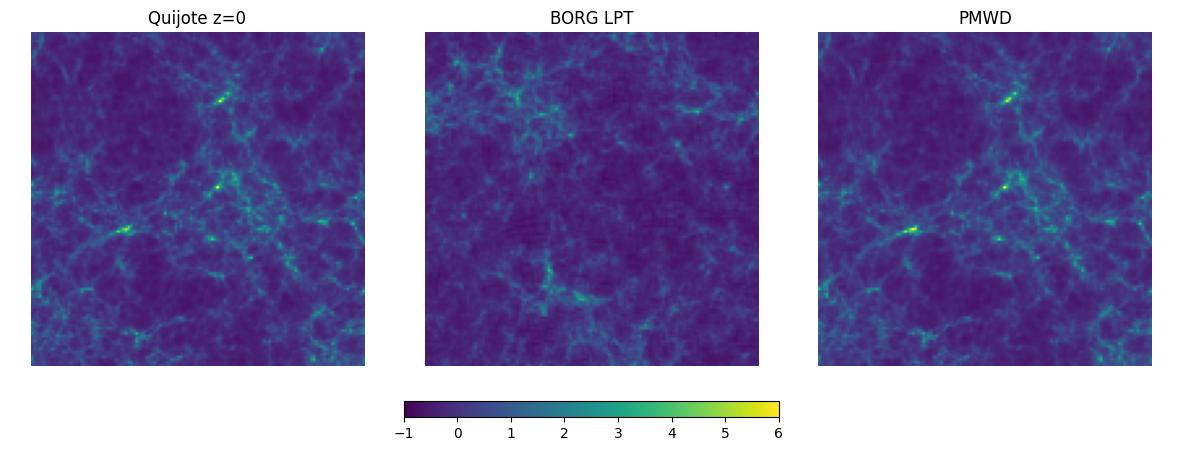

In [104]:
d = 0.2

# plot slices of all 3
fig, axs = plt.subplots(2,3, figsize=(15,5),
                        gridspec_kw={'height_ratios': [1, 0.05],
                                     'wspace': 0.05})

N = qrho.shape[0]//2
delta = int(N*d)
x_ = np.mean(qrho[N:N+delta], axis=0)
im = axs[0,0].imshow(x_, vmin=vmin, vmax=vmax)
axs[0,0].set_title('Quijote z=0')
axs[0,0].axis('off')

N = prho.shape[0]//2
delta = int(N*d)
x_ = np.mean(brho[N:N+delta], axis=0)
im = axs[0,1].imshow(x_, vmin=vmin, vmax=vmax)
axs[0,1].set_title('BORG LPT')
axs[0,1].axis('off')

N = prho.shape[0]//2
delta = int(N*d)
x_ = np.mean(prho[N:N+delta], axis=0)
im = axs[0,2].imshow(x_, vmin=vmin, vmax=vmax)
axs[0,2].set_title('PMWD')
axs[0,2].axis('off')

plt.colorbar(im, cax=axs[1,1], orientation='horizontal')
axs[1,0].axis('off')
axs[1,2].axis('off')

In [105]:
np.std(qrho), np.std(prho), np.std(brho)

(0.90531313, 0.8806049, 0.8157787932375343)

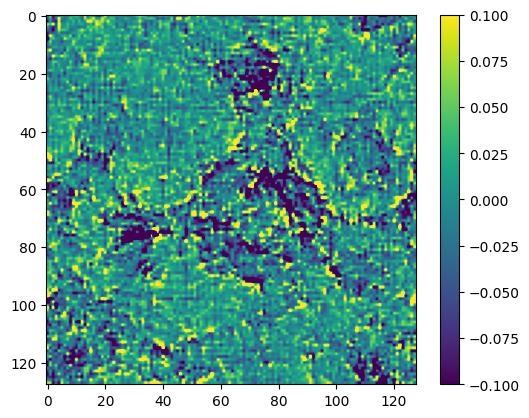

In [106]:
x_ = np.mean(qrho[N:N+delta] - prho[N:N+delta], axis=0)
plt.imshow(x_, vmin=-0.1, vmax=0.1)
plt.colorbar()

In [107]:
Pks = []

import Pk_library as PKL
Pk = PKL.XPk([qrho,prho], 1000, 0, MAS=['CIC','CIC'], threads=1)
Pks.append(Pk)

import Pk_library as PKL
Pk = PKL.XPk([qrho,brho.astype(np.float32)], 
             1000, 0, MAS=['CIC','CIC'], threads=1)
Pks.append(Pk)


Computing power spectra of the fields...
Time FFTS = 0.03
Time loop = 0.05
Time taken = 0.08 seconds

Computing power spectra of the fields...
Time FFTS = 0.03
Time loop = 0.05
Time taken = 0.08 seconds


Text(0.5, 1.0, 'LH: 99')

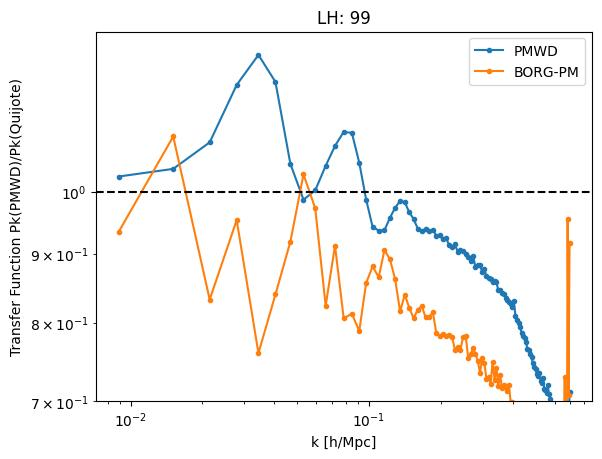

In [108]:
labels = ['PMWD', 'BORG-PM']

for i, Pk in enumerate(Pks):
    k1D      = Pk.k3D
    Pk1D_1   = Pk.Pk[:,0,0]  #field 1
    Pk1D_2   = Pk.Pk[:,0,1]  #field 2
    Pk1D_X   = Pk.XPk[:,0,0] #field 1 - field 2 cross 1D P(k)
    y_ =Pk1D_2/Pk1D_1
    plt.plot(k1D, y_,  '.-', label=f'{labels[i]}')


plt.axhline(1, color='k', ls='--')
plt.loglog()
plt.xlabel('k [h/Mpc]')
plt.ylabel('Transfer Function Pk(PMWD)/Pk(Quijote)');
plt.legend()
plt.ylim(0.7)
plt.title(f'LH: {lhid}')

Text(0.5, 1.0, 'LH: 99')

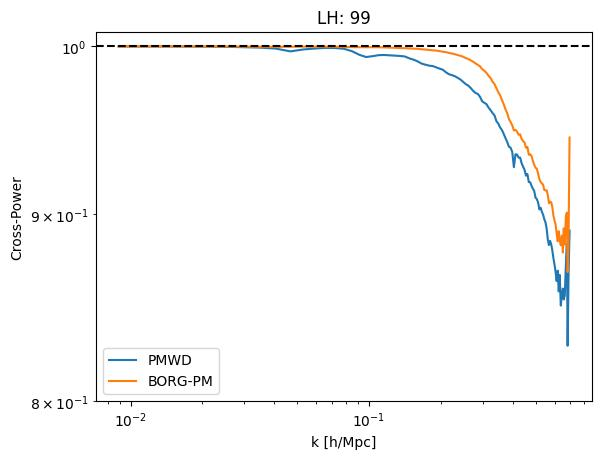

In [84]:
for i, Pk in enumerate(Pks):
    k1D      = Pk.k3D
    Pk1D_1   = Pk.Pk[:,0,0]  #field 1
    Pk1D_2   = Pk.Pk[:,0,1]  #field 2
    Pk1D_X   = Pk.XPk[:,0,0] #field 1 - field 2 cross 1D P(k)
    y_ =Pk1D_X/np.sqrt(Pk1D_1*Pk1D_2)
    plt.plot(k1D, y_, label=f'{labels[i]}')


plt.axhline(1, color='k', ls='--')
plt.loglog()
plt.xlabel('k [h/Mpc]')
plt.ylabel('Cross-Power')
plt.legend()
plt.ylim(0.8)
plt.title(f'LH: {lhid}')

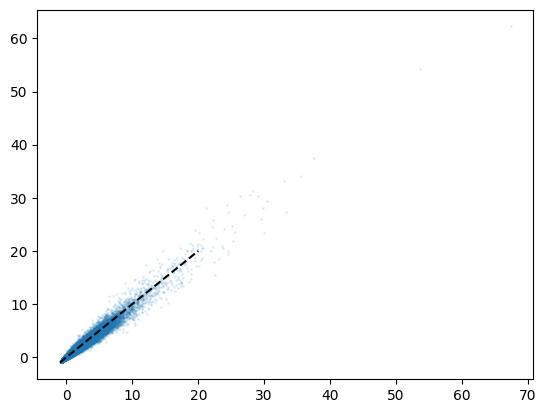

In [99]:
plt.plot([-1,20], [-1,20], 'k--')
plt.scatter(qrho.flatten()[::5], prho.flatten()[::5], s=1, alpha=0.1);

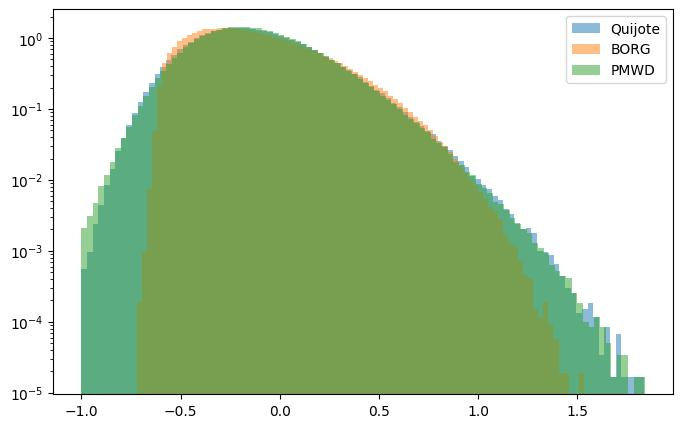

In [100]:
def plot_hist(ax, data, label):
    x_ = np.log10(data.flatten()+1)
    ax.hist(np.log10(data.flatten()+1), bins=100, 
            range=(-1, x_.max()),
            alpha=0.5, label=label, density=True)


f, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_hist(ax, qrho, 'Quijote')
plot_hist(ax, brho, 'BORG')
plot_hist(ax, prho, 'PMWD')
ax.legend()
ax.semilogy();

Quijote has the highest peaks, pmwd has the second highest, and lpt models have the lowest, as expected.


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.08 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds

Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.08 seconds


(0.85, 1.1)

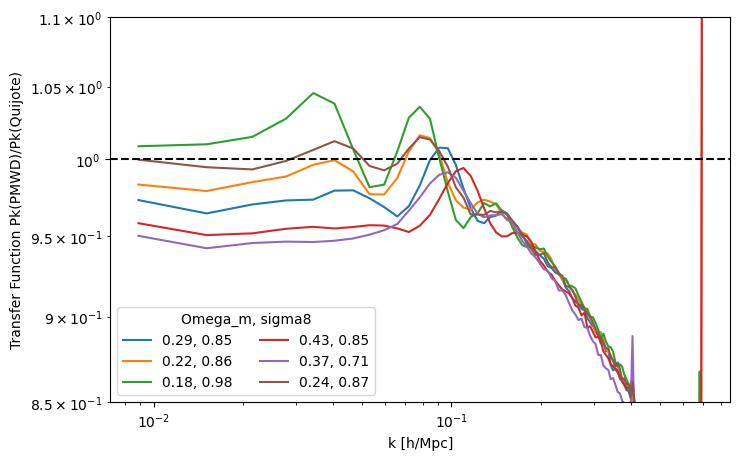

In [282]:
import pandas as pd
# plot the power spectrum bias for many cosmologies
lhids = np.arange(53,59)
cosmos = pd.read_csv('../params/latin_hypercube_params.txt', sep=' ', header=None, 
                     names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'])
colors = [f'C{i}' for i in range(len(lhids))]
# plt.cm.viridis(np.linspace(0, 1, len(lhids)))

f, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, l in enumerate(lhids):
    # Load quijote
    datadir = '/home/mattho/data/quijote/density_field/latin_hypercube/'
    qrho = np.load(pjoin(datadir, str(l), 'df_m_128_z=0.npy'))

    # Load pmwd
    datadir = '/home/mattho/data/cmass-ili/calib_1gpch/pmwd/L1000-N128/'
    prho = np.load(pjoin(datadir, str(l), 'rho.npy'))
    
    XPk = PKL.XPk([qrho,prho], 1000, 0, MAS=['CIC','CIC'], threads=1)
    k1D      = XPk.k3D
    Pk1D_1   = XPk.Pk[:,0,0]  #field 1
    Pk1D_2   = XPk.Pk[:,0,1]  #field 2
    Pk1D_X   = XPk.XPk[:,0,0] #field 1 - field 2 cross 1D P(k)
    y_ =Pk1D_2/Pk1D_1

    ax.plot(k1D, y_, label=f'{cosmos.Omega_m[l]:.2f}, {cosmos.sigma8[l]:.2f}', color=colors[i])

ax.axhline(1, color='k', ls='--')
ax.loglog()
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('Transfer Function Pk(PMWD)/Pk(Quijote)');
ax.legend(title='Omega_m, sigma8', ncols=2)
ax.set_ylim(0.85, 1.1)

## Shivam and Ludvig

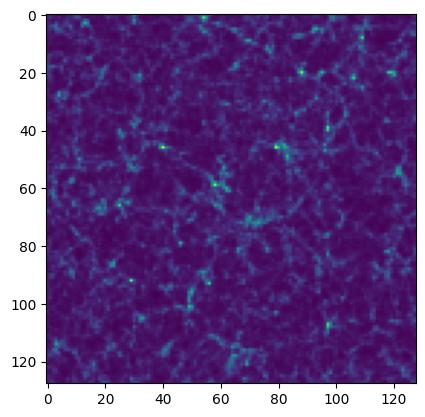

In [8]:
plt.imshow(data[0][100])

## Scratch

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'  # noqa, must go before jax
import jax

import matplotlib.pyplot as plt

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.spec_util import powspec
from pmwd.vis_util import simshow

In [3]:
import jax
if jax.default_backend() == 'gpu':
    ptcl_spacing = 1.  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (256,) * 3
else:
    ptcl_spacing = 4.
    ptcl_grid_shape = (64,) * 3

conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=2)  # 2x mesh shape

In [4]:
cosmo = Cosmology(conf, A_s_1e9=2.0, n_s=0.96, Omega_m=0.3, Omega_b=0.05, h=0.7)
# or simply use the predefined SimpleLCDM
#cosmo = SimpleLCDM(conf)

print(cosmo)

Cosmology(A_s_1e9=Array(2., dtype=float64), n_s=Array(0.96, dtype=float64), Omega_m=Array(0.3, dtype=float64), Omega_b=Array(0.05, dtype=float64), h=Array(0.7, dtype=float64), Omega_k_=None, w_0_=None, w_a_=None, transfer=None, growth=None, varlin=None)


In [5]:
seed = 0
modes = white_noise(seed, conf)

modes = linear_modes(modes, cosmo, conf)

ValueError: Transfer table is empty. Call transfer_integ or boltzmann first.